In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10

# Load the MNIST data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Input image dimensions.
input_shape = x_train.shape[1:]

Using TensorFlow backend.


In [2]:
from model import LogGaussMF
from keras.models import load_model


model = load_model(
    "saved_models/Fuzzy-ResNet56v2_model.9295.h5",
    custom_objects={"LogGaussMF": lambda **x: LogGaussMF(rules=10, **x)})

model.summary()

W0513 15:41:09.460269 140454489925440 deprecation.py:506] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/training/moving_averages.py:210: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
import innvestigate
from keras.models import Model


def analyze_representative(model, representative):
    # outputs needed for analyzing the network
    features_tensor = model.layers[-6].output
    memberships_tensor = model.layers[-5].output
    logits_tensor = model.layers[-2].output
    
    # new model with the outputs from above
    analysis_model = Model(model.inputs, [
        features_tensor,
        memberships_tensor,
        logits_tensor,
    ])
    
    # compute the values of those tensors on the representative
    features, memberships, logits = analysis_model.predict(
        representative.reshape(1, 32, 32, 3))
    
    # find and output the max logit
    logit_val, logit_idx = np.max(logits), np.argmax(logits)
    
    # most relevant membership functions
    R = np.exp(memberships[:,logit_idx,:]) * features
    membership_val = np.max(R)
    membership_idx = np.argmax(R)
    
    model_wo_softmax = Model(model.inputs, [model.layers[-6].output])
    
    # innvestigate seems to have problems with models loaded from disk
    # seems related to the naming of the layers
    # this fixes the problem by catching the error the first time
    try:
        analyzer = innvestigate.create_analyzer(
            "guided_backprop", 
            model_wo_softmax,
            neuron_selection_mode="index",
            allow_lambda_layers=True)
        analyzer.create_analyzer_model()
    except:
        analyzer = innvestigate.create_analyzer(
            "guided_backprop", 
            model_wo_softmax,
            neuron_selection_mode="index",
            allow_lambda_layers=True)
        analyzer.create_analyzer_model()
    
    analysis = analyzer.analyze(
        representative.reshape(1, 32, 32, 3),
        membership_idx).squeeze()
    
    return analysis

10457
6215
19535
6692
33041
45730
1548
13620
5210
44003


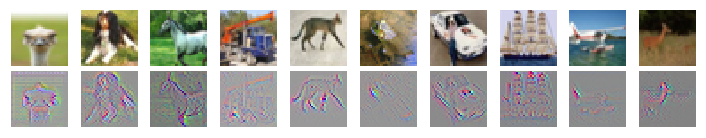

In [4]:
medoids = [10457, 6215, 19535, 6692, 33041, 45730, 1548, 13620, 5210, 44003]

fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    print(medoids[i])
    representative = x_train[medoids[i]]
    axes[0][i].imshow(representative.squeeze())
    
    new_method = analyze_representative(model, representative).reshape(32, 32, 3)
    new_method -= np.min(new_method)
    new_method /= np.max(new_method)
    axes[1][i].imshow(new_method)

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

10457
6215
19535
6692
33041
45730
1548
13620
5210
44003


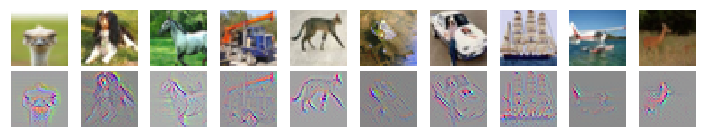

In [5]:
medoids = [10457, 6215, 19535, 6692, 33041, 45730, 1548, 13620, 5210, 44003]


model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    allow_lambda_layers=True)


fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    print(medoids[i])
    representative = x_train[medoids[i]].reshape(1, 32, 32, 3)
    axes[0][i].imshow((representative + x_train_mean).squeeze())
    
    new_method = analyzer.analyze(representative).reshape(32, 32, 3)
    new_method -= np.min(new_method)
    new_method /= np.max(new_method)
    axes[1][i].imshow(new_method)

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig("/home/ryan-desktop/Documents/research-2019/reports/nips19a/figures/medoids/cifar_guided_bp.pdf")

10457
6215
19535
6692
33041
45730
1548
13620
5210
44003


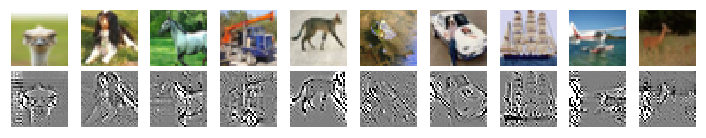

In [6]:
from innvestigate.utils.visualizations import graymap as bk_proj

model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = innvestigate.create_analyzer(
    "guided_backprop", 
    model_wo_softmax,
    allow_lambda_layers=True)


fig, axes = plt.subplots(2, 10, figsize=(10,2))
for i in range(10):
    print(medoids[i])
    representative = x_train[medoids[i]].reshape(1, 32, 32, 3)
    axes[0][i].imshow((representative + x_train_mean).squeeze())
    
    new_method = analyzer.analyze(representative).reshape(32, 32, 3)
    #new_method -= np.min(new_method)
    #new_method /= np.max(new_method)
    axes[1][i].imshow(bk_proj(new_method))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig("/home/ryan-desktop/Documents/research-2019/reports/nips19a/figures/medoids/cifar_guided_bp_bk_proj.pdf")

In [5]:
# def find_representatives(model, n_classes=10):
#     fuzzy_rules = Model(model.inputs, model.layers[-4].output)
#     pred_y = fuzzy_rules.predict(x_train)
    
#     repr_idxs = []
#     for i in range(n_classes):
#         repr_idxs.append(np.argmax(pred_y[:,i]))
    
#     return repr_idxs


# representatives = find_representatives(model)

# fig, axes = plt.subplots(1, 10, figsize=(10,1))
# for i, rep in enumerate(representatives):
#     axes[i].imshow(x_train[rep].squeeze())
#     axes[i].set_title("{}".format(rep))
    
# plt.setp(axes, xticks=[], yticks=[], frame_on=False)

In [6]:
# def compare_methods(model, medoid):
#     fig, axes = plt.subplots(1, 3, figsize=(6,2))
    
#     representative = x_train[medoid]
#     axes[0].imshow(representative.squeeze(), cmap="Greys")
#     axes[0].set_title("Input Image")
    
#     model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
#     analyzer = innvestigate.create_analyzer(
#         "guided_backprop", 
#         model_wo_softmax,
#         allow_lambda_layers=True)
    
#     new_method = analyze_representative(model, representative)
#     new_method -= np.min(new_method)
#     new_method /= np.max(new_method)
#     axes[2].imshow(new_method.squeeze(), cmap="bwr")
#     axes[2].set_title("Proposed Method")
    
#     guided_bp = analyzer.analyze(representative.reshape(1, 32, 32, 3))
#     guided_bp -= np.min(guided_bp)
#     guided_bp /= np.max(guided_bp)
#     axes[1].imshow(guided_bp.squeeze(), cmap="bwr")
#     axes[1].set_title("Guided Backprop")
    
#     plt.setp(axes, xticks=[], yticks=[])
#     plt.tight_layout(h_pad=0, w_pad=0)
    
#     filename = "figures/cifar10_class{}.png"
#     plt.savefig(filename.format(np.argmax(y_train[medoid])))


# for rep in representatives:
#     print("analyzing representative: {}".format(rep))
#     compare_methods(model, rep)